#### Загружаем данные в all_data

In [116]:
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [117]:
train = pd.read_csv('data/train.csv', index_col=0)
print(train.shape)
train.head()

(37518, 3)


,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5


In [118]:
test = pd.read_csv('data/test.csv', index_col=0)
print(test.shape)
test.head()

(7125, 3)


,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini


In [119]:
all_data = pd.concat([train, test], axis=0)
all_data['ts'] = pd.to_datetime(all_data['ts'])

# Доля тест во всей выборке
sum(all_data['user_word'].notnull()) / all_data['user_word'].shape[0] 

0.1595994892816343

### Графички

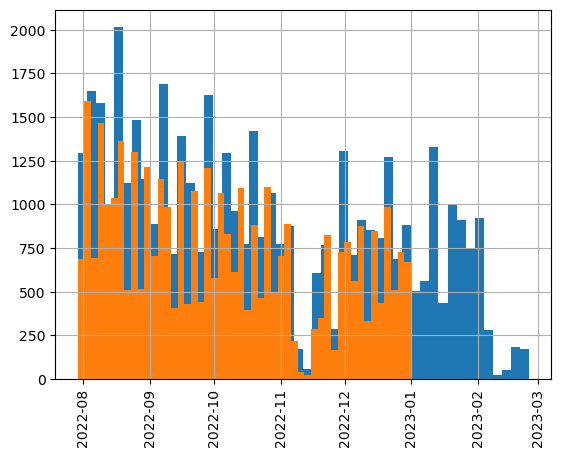

In [120]:
import seaborn as sns

plt.figure()
plt.xticks(rotation='vertical')
all_data['ts'].hist(bins=50)
train['ts'].hist(bins=50)
plt.show()


<Axes: >

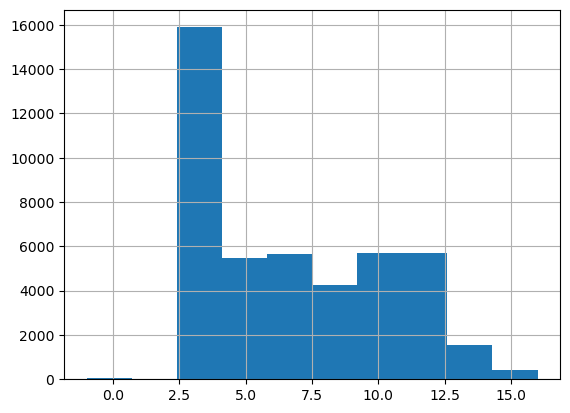

In [121]:
all_data["gate_id"].hist()

### Генерируем новые фичи

In [122]:
train_gate_list = sorted(list(train['gate_id'].unique()))
test_gate_list = sorted(list(test['gate_id'].unique()))

only_train = [gate for gate in train_gate_list if gate not in test_gate_list]
only_test = [gate for gate in test_gate_list if gate not in train_gate_list]

print("Only train gates: ", " ".join(map(str, only_train)))
print("Only test gates: ", " ".join(map(str, only_test)))

Only train gates:  0 16
Only test gates:  2


In [123]:
#1st transformation
#Adding dummies for gates

gates = pd.get_dummies(all_data['gate_id'])
gates.columns = ["gate_" + str(col) for col in gates.columns]
all_data = pd.concat([all_data, gates], axis=1)

all_data.head(1)

,user_id,ts,gate_id,user_word,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,gate_7,gate_8,gate_9,gate_10,gate_11,gate_12,gate_13,gate_14,gate_15,gate_16
0,18.0,2022-07-29 09:08:54,7,NaN,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [124]:
#2nd transformation
#Adding dummies for days of week


days_of_week = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
all_data[days_of_week] = pd.get_dummies(all_data['ts'].dt.day_name())[days_of_week]

In [125]:
#3rd transformation
#Time

all_data['hour'] = all_data['ts'].dt.hour
all_data['minute'] = all_data['ts'].dt.minute
all_data['day'] = all_data['ts'].dt.day
all_data['month'] = all_data['ts'].dt.month


hours = pd.get_dummies(all_data['ts'].dt.hour)
hours.columns = ["h_" + str(col) for col in hours.columns]
all_data[hours.columns] = hours[hours.columns]

In [126]:
# 4th transformation
# Working and not working days

all_data["date"] = all_data["ts"].dt.date
count = all_data.groupby("date").size().reset_index(name='count')
result = pd.merge(all_data, count, on='date', how='left')

result["is_weekend"] = result["count"] < 100
result.drop(["count", "date"], axis=1, inplace=True)

all_data = result


In [127]:
# 5th transformation
# Gate n-grams


all_data["gate_half"] = all_data["gate_id"] <= 8

for i in range(-1, 12):
    all_data["triplet_" + str(i+1)] = (all_data["gate_id"] >= i) & (all_data["gate_id"] <= i+2)
 

In [128]:
# 6th transformation
# Estimate working, departure and arrival time


# Estimate working, departure and arrival time for train and val
stats_train = all_data[all_data.notnull()["user_id"] == True] \
    .groupby(["user_id", "month", "day"]).agg(["min", "max"])["ts"]
stats_train["diff"] = stats_train["max"] - stats_train["min"]
stats_train.rename({"diff": "diff_train", "min": "min_train", "max": "max_train"}, axis=1, inplace=True)
all_data = pd.merge(all_data, stats_train.reset_index(), how="left", on=["user_id", "month", "day"])


# Estimate working, departure and arrival time for test
stats_test = all_data[all_data.notnull()["user_id"] == False] \
    .groupby(["user_word", "month", "day"]).agg(["min", "max"])["ts"]
stats_test["diff"] = stats_test["max"] - stats_test["min"]
stats_test.rename({"diff": "diff_test", "min": "min_test", "max": "max_test"}, axis=1, inplace=True)
all_data = pd.merge(all_data, stats_test.reset_index(), how="left", on=["user_word", "month", "day"])


# Set unified column name
all_data["diff"] = all_data["diff_train"].fillna(all_data["diff_test"])
all_data["min"] = all_data["min_train"].fillna(all_data["min_test"])
all_data["max"] = all_data["max_train"].fillna(all_data["max_test"])

# Drop auxiliary columns
all_data.drop(["min_train", "max_train", "diff_train"], axis=1, inplace=True)
all_data.drop(["min_test", "max_test", "diff_test"], axis=1, inplace=True)


In [129]:
# 7th transformation
# Transform times from 6th point
all_data["diff_hour"] = all_data["diff"].dt.seconds // 3600
all_data["diff_min"] = all_data["diff"].dt.seconds % 3600 // 60

all_data["arrival_hour"] = all_data["min"].dt.hour
all_data["arrival_min"] = all_data["min"].dt.minute

all_data["departure_hour"] = all_data["max"].dt.hour
all_data["departure_min"] = all_data["max"].dt.minute

all_data.drop(["diff", "min", "max"], axis=1, inplace=True)

In [130]:
all_data

,user_id,ts,gate_id,user_word,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,triplet_9,triplet_10,triplet_11,triplet_12,diff_hour,diff_min,arrival_hour,arrival_min,departure_hour,departure_min
0,18.0,2022-07-29 09:08:54,7,NaN,False,False,False,False,False,False,...,False,False,False,False,9,33,9,8,18,41
1,18.0,2022-07-29 09:09:54,9,NaN,False,False,False,False,False,False,...,True,True,False,False,9,33,9,8,18,41
2,18.0,2022-07-29 09:09:54,9,NaN,False,False,False,False,False,False,...,True,True,False,False,9,33,9,8,18,41
3,18.0,2022-07-29 09:10:06,5,NaN,False,False,False,False,False,False,...,False,False,False,False,9,33,9,8,18,41
4,18.0,2022-07-29 09:10:08,5,NaN,False,False,False,False,False,False,...,False,False,False,False,9,33,9,8,18,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44638,NaN,2023-02-24 19:43:36,11,collinear,False,False,False,False,False,False,...,False,True,True,True,9,31,10,12,19,44
44639,NaN,2023-02-24 19:44:00,4,collinear,False,False,False,False,False,True,...,False,False,False,False,9,31,10,12,19,44
44640,NaN,2023-02-24 19:44:01,4,collinear,False,False,False,False,False,True,...,False,False,False,False,9,31,10,12,19,44
44641,NaN,2023-02-24 19:44:09,9,collinear,False,False,False,False,False,False,...,True,True,False,False,9,31,10,12,19,44


In [131]:
all_data[(all_data['user_word'] == "collinear") & (all_data['month'] == 2) & (all_data['day'] == 24)].shape

(13, 75)

In [132]:
# 8th transformation
# Gates number


all_data['count_train'] = all_data.groupby(['user_id', 'month', 'day'])['ts'].transform('count')
all_data['count_test'] = all_data.groupby(['user_word', 'month', 'day'])['ts'].transform('count')
all_data['gates_today'] = all_data['count_train'].fillna(all_data['count_test'])
all_data.drop(['count_train', 'count_test'], axis=1, inplace=True)


forsomereason = all_data.groupby(['user_id'])['gates_today'].agg(["mean", "std"])
forsomereason.rename({"mean": "mean_train", "std": "std_train"}, axis=1, inplace=True)
all_data = pd.merge(all_data, forsomereason, on="user_id", how="left")

forsomereason = all_data.groupby(['user_word'])['gates_today'].agg(["mean", "std"])
forsomereason.rename({"mean": "mean_test", "std": "std_test"}, axis=1, inplace=True)
all_data = pd.merge(all_data, forsomereason, on="user_word", how="left")
all_data["gates_avg"] = all_data["mean_train"].fillna(all_data["mean_test"])
all_data["gates_std"] = all_data["std_train"].fillna(all_data["std_test"])
all_data.drop(['mean_train', 'mean_test', "std_test", "std_train"], axis=1, inplace=True)


In [133]:
print(all_data.columns, len(all_data.columns))

Index(['user_id', 'ts', 'gate_id', 'user_word', 'gate_-1', 'gate_0', 'gate_1',
       'gate_2', 'gate_3', 'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8',
       'gate_9', 'gate_10', 'gate_11', 'gate_12', 'gate_13', 'gate_14',
       'gate_15', 'gate_16', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'hour', 'minute', 'day', 'month', 'h_0',
       'h_1', 'h_3', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12',
       'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21',
       'h_22', 'h_23', 'is_weekend', 'gate_half', 'triplet_0', 'triplet_1',
       'triplet_2', 'triplet_3', 'triplet_4', 'triplet_5', 'triplet_6',
       'triplet_7', 'triplet_8', 'triplet_9', 'triplet_10', 'triplet_11',
       'triplet_12', 'diff_hour', 'diff_min', 'arrival_hour', 'arrival_min',
       'departure_hour', 'departure_min', 'gates_today', 'gates_avg',
       'gates_std'],
      dtype='object') 78


In [134]:
train['ts'].agg(['max','count'])

max      2022-12-31 20:39:31
count                  37518
Name: ts, dtype: object

In [135]:
test['ts'].agg(['min','max','count'])

min      2023-01-03 08:21:00
max      2023-02-24 19:44:09
count                   7125
Name: ts, dtype: object

### Подготовить трэйн и валидацию

В результате получается два датафрейма.
- train - записи с начала до 30 ноября
- validation - записи с 30 ноября до 31 декабря

In [136]:
# Подготовим данные для train, test

train_idx = all_data['user_word'].isnull()
not_test = all_data[train_idx].copy()

In [137]:
val_index = not_test['ts'] > '2022-11-30'

train = not_test[~val_index].copy()
validation = not_test[val_index].copy()

In [138]:
train.shape, all_data.shape, validation.shape

((30535, 78), (44643, 78), (6983, 78))

In [139]:
# # Подготовим данные для train, validation из train


# X = train[~val_index].copy()
# X_val = train[val_index].copy()

# y = X['user_id'].astype(int)
# y_val = X_val['user_id'].astype(int)

# #Доля на валидации
# sum(val_index) / val_index.shape[0]

### Варианты с классическим ML

In [140]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [141]:
y = train["user_id"].astype(int)
X = train.drop(["user_id", "user_word", "ts"], axis=1)

y_val = validation["user_id"].astype(int)
X_val = validation.drop(["user_id", "user_word", "ts"], axis=1)

##### Scaling (отключен)

In [142]:
to_scale = True


if to_scale:
    
    # Сделаем нормирование 
    scaler_X = StandardScaler()
    scaler_X_val = StandardScaler()
    
    X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
    X_val = pd.DataFrame(scaler_X_val.fit_transform(X_val), columns=X_val.columns)

    

##### Начинаем обучени
Моделька запихивается в переменную model, чтоб потом можно было ее обучить на настоящем train

In [143]:

model = KNeighborsClassifier(n_neighbors=15, metric='cosine') #104 14
# model = CatBoostClassifier(learning_rate=0.01, loss_function='MultiClass', num_trees=10000)
# model = RandomForestClassifier(n_estimators=1000, max_depth=30, min_samples_split=10)
clf = model.fit(X, y)

y_pred = clf.predict(X)

y_val_pred = clf.predict(X_val)


##### Избавимся от повторов в ответах

In [933]:
y_pred_proba = clf.predict_proba(X)
y_pred_proba.shape


(30535, 50)

In [949]:


y_word = pd.DataFrame()
y_word['word'] = 'user_' + y.astype(str)
y_word['true'] = y


for i in range(y_pred_proba.shape[1]):
    col = y_pred_proba[:,i]
    y_word['preds_' + str(i)] = col


y_word.groupby(["word"]).mean()


,true,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,preds_6,preds_7,preds_8,...,preds_40,preds_41,preds_42,preds_43,preds_44,preds_45,preds_46,preds_47,preds_48,preds_49
word,,,,,,,,,,,,,,,,,,,,,
user_0,0.0,0.232356,0.048586,0.034974,0.000000,0.000000,0.043455,0.002513,0.000524,0.018220,...,0.027539,0.019581,0.021257,0.033403,0.000000,0.039267,0.012880,0.065236,0.001257,0.020000
user_1,1.0,0.055032,0.284047,0.087259,0.000000,0.000000,0.035867,0.000000,0.000000,0.011242,...,0.025589,0.013919,0.014882,0.022270,0.000000,0.027837,0.002570,0.045824,0.000107,0.007923
user_11,11.0,0.033141,0.022543,0.014066,0.000000,0.000000,0.054046,0.000000,0.000000,0.025915,...,0.024663,0.022447,0.022929,0.030250,0.000000,0.048362,0.017919,0.055395,0.002890,0.027360
user_12,12.0,0.026650,0.005562,0.006785,0.000000,0.000000,0.033191,0.001589,0.000856,0.057885,...,0.020905,0.008313,0.029279,0.018949,0.000306,0.045355,0.013875,0.027323,0.003851,0.009719
user_14,14.0,0.007061,0.003053,0.001908,0.000000,0.000000,0.009733,0.000000,0.000000,0.014695,...,0.018130,0.006298,0.012786,0.007824,0.000000,0.004008,0.021183,0.005916,0.000191,0.001908
user_15,15.0,0.020328,0.041705,0.035672,0.000000,0.000000,0.038033,0.000000,0.000066,0.027869,...,0.044262,0.011016,0.021246,0.019213,0.000000,0.038820,0.017246,0.050164,0.000525,0.011803
user_17,17.0,0.041108,0.063848,0.036735,0.000000,0.000000,0.027114,0.000000,0.000000,0.019242,...,0.012245,0.005248,0.003499,0.014869,0.000000,0.033819,0.010204,0.082507,0.001458,0.017493
user_18,18.0,0.018909,0.044797,0.052728,0.000000,0.000000,0.059898,0.000381,0.000000,0.007170,...,0.018464,0.008756,0.012183,0.014023,0.000000,0.025317,0.009201,0.035723,0.000317,0.010343
user_19,19.0,0.014718,0.008047,0.003714,0.000000,0.000000,0.063686,0.000000,0.000344,0.028748,...,0.030605,0.018432,0.013549,0.026204,0.000000,0.057290,0.033494,0.035970,0.000963,0.008597


In [936]:
max_values = y_word.groupby(["word"]).mean().idxmax(axis=0)
max_values

true        user_57
preds_0      user_0
preds_1      user_1
preds_2      user_3
preds_3      user_4
preds_4      user_5
preds_5      user_6
preds_6      user_7
preds_7      user_8
preds_8      user_9
preds_9     user_11
preds_10    user_52
preds_11    user_14
preds_12    user_15
preds_13    user_17
preds_14    user_18
preds_15    user_19
preds_16    user_20
preds_17     user_5
preds_18    user_23
preds_19    user_24
preds_20    user_25
preds_21    user_26
preds_22    user_27
preds_23    user_28
preds_24    user_29
preds_25    user_31
preds_26    user_32
preds_27    user_33
preds_28     user_4
preds_29    user_35
preds_30    user_36
preds_31    user_37
preds_32    user_38
preds_33    user_39
preds_34    user_40
preds_35    user_41
preds_36    user_42
preds_37    user_43
preds_38    user_45
preds_39    user_46
preds_40    user_47
preds_41    user_48
preds_42    user_49
preds_43    user_50
preds_44    user_52
preds_45    user_53
preds_46    user_54
preds_47    user_55
preds_48    user_56


### Нейросетевая попытка

In [565]:
X.drop(["ts", "user_word"], axis=1, inplace=True)
X_val.drop(["ts", "user_word"], axis=1, inplace=True)

In [573]:
len(X["user_id"].unique())

50

In [577]:
sorted(X["user_id"].unique())

[0.0,
 1.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 11.0,
 12.0,
 14.0,
 15.0,
 17.0,
 18.0,
 19.0,
 20.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0]

In [567]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dataframe, target_column):
        self.dataframe = dataframe
        self.target_column = target_column

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Получаем данные и метки
        row = self.dataframe.iloc[idx]
        features = row.drop(self.target_column).values.astype(float)  # Входные данные
        label = row[self.target_column]  # Целевая переменная
        
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


# Создаем экземпляр Dataset
target_column = 'user_id'
dataset = CustomDataset(X, target_column)

# Создаем DataLoader
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [578]:
import torch
import torch.nn as nn
import torch.optim as optim

# Определяем архитектуру модели
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim1)
        self.hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.output = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

# Параметры модели
input_dim = 72  # размерность входных данных
hidden_dim1 = 150
hidden_dim2 = 300
output_dim = 58  # размерность выходных данных (например, для классификации на 3 класса)

# Создаем модель
model = MLP(input_dim, hidden_dim1, hidden_dim2, output_dim)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели (пример)
def train(model, data_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Извлечение векторов из скрытого слоя
def get_hidden_vectors(model, inputs):
    with torch.no_grad():
        hidden_layer_output = torch.relu(model.hidden1(inputs))
        return hidden_layer_output

train(model, data_loader, criterion, optimizer)

# Получение вектора пользователя
user_data = torch.randn(1, input_dim)  # пример входных данных для одного пользователя
user_vector = get_hidden_vectors(model, user_data)
print("User vector from hidden layer:", user_vector)


Epoch [1/10], Loss: 4.5669
Epoch [2/10], Loss: 1.9147
Epoch [3/10], Loss: 0.4321
Epoch [4/10], Loss: 2.3233
Epoch [5/10], Loss: 1.2663
Epoch [6/10], Loss: 2.9918
Epoch [7/10], Loss: 0.0277
Epoch [8/10], Loss: 0.0565
Epoch [9/10], Loss: 1.1620
Epoch [10/10], Loss: 0.0210
User vector from hidden layer: tensor([[ 0.3591,  0.0000,  1.6366,  0.5369,  0.0000,  0.0000,  0.0000,  0.0000,
         10.6264,  0.4246,  0.2583,  0.0000,  0.0000,  0.5845,  0.1144,  3.5070,
          0.0000,  0.0430,  0.0000,  0.0000,  3.4792,  3.2731,  0.3296,  0.3803,
          1.0154,  0.4255,  0.0000,  0.0257,  0.7121,  1.0507,  0.0000,  1.3996,
          0.0000,  0.0651,  0.0000,  0.0000,  5.8750,  0.0000,  0.0000,  0.0000,
          0.2281,  0.5439,  0.0000,  0.3879,  0.3671,  0.3158,  0.0000,  0.0000,
          0.0000,  6.7179,  0.7611,  0.4259,  0.1662,  0.7356,  0.0000,  0.4897,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.3409,  5.3575,  0.0000,
          0.0000,  0.2504,  0.1535,  0.0000,  0.00

In [579]:
dataset_val = CustomDataset(X_val, target_column)

In [594]:
X_val.shape

(6983, 73)

In [595]:
# Создаем экземпляр Dataset для тестовых данных
val_dataset = CustomDataset(X_val, target_column)

# Создаем DataLoader для тестовых данных
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Применяем модель к тестовым данным
model.eval()  # Устанавливаем модель в режим оценки

y_val_pred = []
with torch.no_grad():  # Отключаем градиенты для тестирования
    for inputs, labels in val_loader:
        outputs = model(inputs)  # Применяем модель к входным данным
        _, predicted = torch.max(outputs, 1)  # Получаем индексы максимальных значений
        y_val_pred.extend(predicted.numpy())

In [596]:
val_loader.dataset.__len__()

6983

In [597]:
# Делаем валидацию нашей модель
y_val_word = pd.DataFrame()


y_val_word['word'] = 'user_' + y_val.astype(str) 

y_val_word['true'] = y_val

y_val_word['preds'] = y_val_pred

y_val_pred_word = pd.DataFrame(y_val_word.groupby('word')[['true','preds']].agg(lambda x: x.value_counts().index[0]))

y_val_pred_word['comp'] = y_val_pred_word['preds'] == y_val_pred_word['true']

y_val_pred_word['norm'] = 1


### Оцениваем качество

In [144]:
# Делаем валидацию нашей модель

# Создаем новые датасеты
y_word = pd.DataFrame()
y_val_word = pd.DataFrame()


# Что типа id в тестовой выборке
y_word['word'] = 'user_' + y.astype(str)
y_val_word['word'] = 'user_' + y_val.astype(str) 

# Целевая переменная ground truth
y_word['true'] = y
y_val_word['true'] = y_val

# Добавим предсказания
y_word['preds'] = y_pred
y_val_word['preds'] = y_val_pred



# Делаем датасеты с предсказаниями
y_pred_word = pd.DataFrame(y_word.groupby('word')[['true','preds']].agg(lambda x: x.value_counts().index[0]))
y_val_pred_word = pd.DataFrame(y_val_word.groupby('word')[['true','preds']].agg(lambda x: x.value_counts().index[0]))

# Добавляем сравнение с ground truth
y_pred_word['comp'] = y_pred_word['preds'] == y_pred_word['true']
y_val_pred_word['comp'] = y_val_pred_word['preds'] == y_val_pred_word['true']


# Веса юзеров мы не знаем, давайте возьмем равные веса для простоты = 1. Можно и не брать пролли
y_pred_word['norm'] = 1
y_val_pred_word['norm'] = 1


In [145]:
# Оцениваем на train

true_answers = (y_pred_word['comp'] * y_pred_word['norm']).sum()
total_answers = y_pred_word['norm'].sum()
precent_true = round((true_answers/total_answers)*100, 1)

print('Оценка train2', true_answers, total_answers, precent_true)

Оценка train2 38 50 76.0


In [146]:
# Оцениваем на val

true_answers_val = (y_val_pred_word['comp'] * y_val_pred_word['norm']).sum()
total_answers_val = y_val_pred_word['norm'].sum()
precent_true_val = round((true_answers_val/total_answers_val)*100, 1)

print('Оценка val', true_answers_val, total_answers_val, precent_true_val)

Оценка val 14 43 32.6


### Готовим сабмит

In [106]:
n = all_data[all_data["user_id"].notna()].shape[0]
train_df = all_data[:n]
test_df = all_data[n:]

In [107]:
y_train = train_df["user_id"].astype(int)
X_train = train_df.drop(["user_id", "user_word", "ts"], axis=1)
X_test = test_df.drop(["user_id", "user_word", "ts"], axis=1)

In [108]:
scaler_X = StandardScaler()
scaler_X_test = StandardScaler()

X_train = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler_X_test.fit_transform(X_test), columns=X_test.columns)

In [109]:
clf = model.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)

y_test_pred = clf.predict(X_test)

In [908]:
y_train.head(5)

0    18
1    18
2    18
3    18
4    18
Name: user_id, dtype: int32

In [911]:
clf.predict_proba(X_train.head(5))

array([[0. , 0.4, 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.1, 0. , 0. ],
       [0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. ],
       [0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. ],
       [0. , 0.2, 0. , 0. , 0. , 0. ,

In [110]:
test_words = pd.DataFrame()

test_words['user_word'] = test['user_word']
test_words['preds'] = y_test_pred

comp_df_test = pd.DataFrame(test_words.groupby('user_word')['preds'].agg(lambda x: x.value_counts().index[0]))

comp_df_test.to_csv('answer.csv') 


In [897]:
! zip answer.zip answer.csv # Подготовка файла для отправки

'zip' is not recognized as an internal or external command,
operable program or batch file.
